In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import uproot


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
tf.data.experimental.enable_debug_mode()

Instructions for using and understanding the AutoEncoder with DeltaRij matrix as input. This ML algorithm was run in Keras environment using Python 3.7. 

1) The first step is to import the different libraries for the programme. As it can be seen, numpy, matplotlib, pandas and tensorflow are compulsory. In addition, uproot would be necessary to tranform a .root file into a pandas dataframe. The SM Simulation was done by the supervisors using MonteCarlo, although it can be done using the pythia environment from the SUEP Tutorial on Docker (Example Number 35 in the examples of pythia, selecting soft QCD as main interaction and 13TeV as center of mass energy  ). In addition, other tensorflow specific modules are imported as they will be helpful when building the model

2) Now SM data is opened thanks to uproot

3) The tf.data.experimental.enable_debug_mode() is necessary when using Sigma Function from SUEP Paper (https://arxiv.org/pdf/2107.12379.pdf) as Loss Function.



In [2]:
my_file = uproot.open('MinBias.root') #Open file
tree = my_file['TupleTest/TupleTest'] #I go to the main tree of the file
data_df = tree.arrays(library='pd') # I turn the tree into a pandas dataframe
my_file.close()  # we close the document

# Show the first 5 lines of the DataFrame
data_df.head()

Px          Py            Pz          Pt             E       Eta  \
0  -82.360001   46.580002  14412.629883   94.619583  14412.940430  5.719154   
1  -19.600000   53.840000  40730.078125   57.296646  40730.121094  7.259628   
2  -69.949997 -161.399994  68758.343750  175.906113  68758.703125  6.661551   
3  422.029999 -423.790009   7772.229980  598.086365   7810.824707  3.259202   
4  -89.269997   50.880001    624.719971  102.751678    648.315491  2.504831   

        Phi     ID     PVx     PVy      PVz         OVx      OVy  \
0  2.626877   22.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
1  1.919925   22.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
2 -1.979756  211.0 -0.0239  0.0114  80.8918   -0.023900   0.0114   
3 -0.787479  321.0 -0.0239  0.0114  80.8918 -101.334999 -24.0208   
4  2.623557 -211.0 -0.0239  0.0114  80.8918 -101.334999 -24.0208   

            OVz   flight_dx  flight_dy     flight_dz  evtNumber  pvID    nPVs  
0     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
1     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
2     80.891800    0.000000     0.0000      0.000000        1.0   0.0  5512.0  
3  10298.225586  101.311096    24.0322  10217.333984        1.0   0.0  5512.0  
4  10298.225586  101.311096    24.0322  10217.333984        1.0   0.0  5512.0

Now SM Simulation Data will be treated. First, cuts will be done on tracks according to VELO Acceptance -> Eta =[-4.5 , -1] U [1, 4.5]

1) First, variables are turned into numpy arrays
2) After, empty lists will be created, where data after cut will be hed.
3) Cuts are applied and lists are transformed to arrays

In [3]:
Pt=data_df['Pt'].to_numpy() #transversal momentum (MeV)
Eta=data_df['Eta'].to_numpy() #Eta
Phi=data_df['Phi'].to_numpy() #Phi
NEvent=data_df['evtNumber'].to_numpy() #Number of the event (not much important)
E=data_df['E'].to_numpy() # Energy of the track
Pz=data_df['Pz'].to_numpy() #Momentum on Z axis (MeV)
PVI=data_df['pvID'].to_numpy() #Primary Vertex Index ->> MUCH IMPORTANT, we can differentiate between events on this way
fly=data_df['flight_dz'].to_numpy() #Distance of flight through z axis (collision axis)
Px=data_df['Px'].to_numpy() #Momentum on x axis (MeV)
Py=data_df['Py'].to_numpy() #Momentum on y axis (MeV)

Etadef=[] #Empty lists were variables would be put after applying cuts
Ptdef=[]
Phidef=[]
Neventdef=[]
Edef=[]
flydef=[]
PVIdef=[]
Pzdef=[]
Pydef=[]
Pxdef=[]




for i in range(len(Eta)):
    if (Eta[i] >1.0 and Eta[i]<4.5) or (Eta[i] >-4.5 and Eta[i]<-1.0) : #Conditions on eta [-4.5, -1] U [1, 4.5]
        if Pt[i]>250.0 and Pt[i] <75000. and fly[i] < 1: #Conditions on Pt and fly distance (<75 GeV and fly < 1mm)
            Etadef.append(Eta[i])
            Ptdef.append(Pt[i])
            Phidef.append(Phi[i])
            Neventdef.append(NEvent[i])
            Edef.append(E[i])
            flydef.append(fly[i])
            PVIdef.append(PVI[i])
            Pzdef.append(Pz[i])
            Pxdef.append(Px[i])
            Pydef.append(Py[i])
        else:
            continue
        
Ptdef=np.array(Ptdef) #Transform to array all the lists
Etadef=np.array(Etadef)
Phidef=np.array(Phidef)
Phidef=Phidef+np.pi #IMPORTANT: FOR NORMALIZATION I CHANGED PHI FROM [-pi, pi] tp [0, 2pi]
Pxdef=np.array(Pxdef)
Pydef=np.array(Pydef)
Pzdef=np.array(Pzdef)
Edef=np.array(Edef)

Ptdef=Ptdef/1000. #GeV  #I divide in order to have all the data in GeV
Pxdef=Pxdef/1000. #GeV
Pydef=Pydef/1000. #GeV
Pzdef=Pzdef/1000. #GeV
Edef=Edef/1000. #GeV


Now we pass to the treatment of SM data to the AutoEncoder. Following steps were followed

1. First I run those functions from scikit learn in order to normalize afterwards. IMPORTANT: TWO NORMALIZATION METHODS WERE FOLLOWED. THESE MODULES IMPORTED ARE THE FISRT OF THEM; THE SECOND ONE CAN BE OBTAINED IN OTHER WAY.

2. I define the tracks per event as well as lists were data for train and test will be stored. We will take the whole data and take around 85% for training and 15% for test. We have two variables for counting the number of training and test events. As cuts are variable, these numbers are succeptible to change and according to the situation, they have to be changed to keep the 85% - 15% ratio.

3. I check the vertex ID list, and whilst it doesn't change (the PV is the same), I count the number of tracks. When Index change, another primary vertex appears and according to the number of tracks I take the event or discard it (if larger to the numberoftracks constraint I take it).

4. I keep in list 3 variables: Transversal momentum, eta and phi. I also create a matrix were DelraRij will be kept. Afterwards I order all the tracks according to the bigger value of pt, such as in SUEP Paper: https://arxiv.org/pdf/2107.12379.pdf)

5. Then I apply the normalization. For that I have to reshape the lists and then apply the reshapement (it works in a specific axis, and reshaping os the way to do it). Once the data is reshaped I do the operations from DeltaRij and keep it there

6. Now (if necessary) can lineall normalize the matrix in other way just doing one operation (This step is not necessary is the previous normalization was done)

7. Now I keep the data in train and test datasets according to the 85% - 15 % ratios.

8. I define two tensors where I will keep train and test datasets in the correct shape for the Encoder.



In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale #For normalazing

scPt=MinMaxScaler(feature_range=(0,1)) # Normalizers for the variables of interest
scEta=MinMaxScaler(feature_range=(0,1))
scPhi=MinMaxScaler(feature_range=(0,1))


b=104 #tracks per event
input_train=[]
input_test=[]
cuentatrain=0
cuentatest=0 #Initial variables for counting test and train datasets as well as keeping the data


a=0
for i in range(len(PVIdef)-1): #I check the PVIdef list and when I pass from one event to the following I do a comparison
    if int(PVIdef[i+1])==PVIdef[i]:
        a+=1
    else:
        if a>=b: #If the number of tracks is bigger than cutoof I take the event
            pteventos=[]
            Etaeventos=[]
            Phieventos=[] #Data from the event will be kept in here
            

    
            Rij=np.ones([b,b]) #DeltaRij matrix
            NF,NC=np.shape(Rij)
            pteventos=np.array(Ptdef[i-a:i+1]) #I take the data of the event, caution to the inside of the brackets
            Etaeventos=np.array(Etadef[i-a:i+1])
            Phieventos=np.array(Phidef[i-a:i+1])
           
            
            ptML=[] #Lists after ordering 
            EtaML=[]
            PhiML=[]

            for j in range(b): #Now we are going to the take the highest pt tracks
                ptML.append(max(pteventos));indice=np.argmax(pteventos) #I take the maximun and its argument
                EtaML.append(Etaeventos[indice]) #I take the index for that max pt specific track
                PhiML.append(Phieventos[indice])
                pteventos=np.delete(pteventos,indice) #I delete the maximum and do it again
                Etaeventos=np.delete(Etaeventos,indice) #Same for eta and phi, I delete that track
                Phieventos=np.delete(Phieventos,indice)

            
            #Now the normalization comes
        
        
            ptML=np.array(ptML).reshape(-1,1)
            ptML=scPt.fit_transform(ptML) #I take all the elements as [],[],[] and then do the
            EtaML=np.array(EtaML).reshape(-1,1) #normalization
            EtaML=scEta.fit_transform(EtaML) 
            PhiML=np.array(PhiML).reshape(-1,1)
            PhiML=scPhi.fit_transform(PhiML)
   



        
        
            
            
            
            for k in range(NF):#I associate the matrix all the normalized data
                for m in range(NC):
                    if k>m:
                        Rij[k,m]=np.sqrt((EtaML[k][0]-EtaML[m][0])**2 + (PhiML[k][0]-PhiML[m][0])**2)
                    if k==m:
                        Rij[k,m]=np.sqrt((EtaML[k][0]**2 + PhiML[k][0]**2))
                    if k<m:
                        Rij[k,m]=0.
    
            #Rij=(Rij - Rij.min()) / (Rij.max() - Rij.min()) #Second NORMALIZATION if the previous one was not done yet

                
            if cuentatrain >= 2600 : #This is the number of train events I choose for this specific acceptance ratio to keep 85-15 %
                input_test.append(Rij)
                cuentatest+=1 #I put +1 to test if the maximun training number is reached
                a=0 #a turns to 0 to start with the following Primary Vertex 
            else:
                input_train.append(Rij)
                cuentatrain+=1
                a=0
        else:
            a=0
            
deftrain=np.ones([cuentatrain,b,b]) #I define the tensor which will keep the data for the train
deftest=np.ones([cuentatest,b,b]) #Same for test
for i in range(cuentatrain):
    for j in range(b):
        for k in range(b):
            deftrain[i,j,k]=input_train[i][j,k] #I just do a loop over the number of events and the dimensions of the matrix
            
            

for i in range(cuentatest): #Same for the test set
    for j in range(b):
        for k in range(b):
            deftest[i,j,k]=input_test[i][j,k]
            
            
            

In [5]:
cuentatrain #I just take these to make a fast checking

2600

In [6]:
deftrain.shape #Same for the dimensions of the matrix

(2600, 104, 104)

Now I do exactly the same for the SUEP data set. On this case, I am only going to take the same number of test events of SM in order to stablish afterward a correct comparison (for example, comparing 300 SM and 300 SUEP events). The SUEP comparison set will be held in the deftrainSUEP tensor (the other one just keep the rest of events). 

1. On this case, I firstly open the csv into a pandas dataframe and then I turn the variables of interest into arrays.

2. Caution with the inside of the brackets on this case, as it changes in comparison with the SM data set

3. The procedures are quite similar to the SM one

In [7]:
#Now we follow the same strategy with SUEPs
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

scPtSUEP=MinMaxScaler(feature_range=(0,1))
scEtaSUEP=MinMaxScaler(feature_range=(0,1))
scPhiSUEP=MinMaxScaler(feature_range=(0,1))
scESUEP=MinMaxScaler(feature_range=(0,1))
scPzSUEP=MinMaxScaler(feature_range=(0,1)) #take normalizers

dataSUEP=pd.read_csv("SUEP_Simulation_10kDM_Eta11.csv") #I open the csv of the simulations
dfSUEP=pd.DataFrame(dataSUEP)
nTracksSUEP=dfSUEP['nTracks'].to_numpy()
nEventsSUEP=dfSUEP['Nevents'].to_numpy()
ptSUEP=dfSUEP["trackPt"].to_numpy()
etaSUEP=dfSUEP["trackEta"].to_numpy()
phiSUEP=dfSUEP["trackPhi"].to_numpy()
phiSUEP= phiSUEP + np.pi
ESUEP=dfSUEP['trackE'].to_numpy()
PzSUEP=dfSUEP['trackPz'].to_numpy()
PxSUEP=dfSUEP['trackPx'].to_numpy()
PySUEP=dfSUEP['trackPy'].to_numpy() #I put all the data files to numpy arrays

b=104 #tracks per event
input_trainSUEP=[]
input_testSUEP=[]
cuentatrainSUEP=0
cuentatestSUEP=0
totPtSUEP=[]
totEtaSUEP=[]
totPhiSUEP=[] 
pttestSUEP=[]
EtatestSUEP=[]
PhitestSUEP=[]


for i in range(len(nEventsSUEP)-1):
    d=int(nEventsSUEP[i])
    if int(nEventsSUEP[i+1])!=d:
        a=int(nTracksSUEP[i])
        if a>=b:
            pteventosSUEP=[]
            EtaeventosSUEP=[]
            PhieventosSUEP=[]


    
            RijSUEP=np.ones([b,b])
            NF,NC=np.shape(RijSUEP)
            pteventosSUEP=np.array(ptSUEP[i-a+1:i+2]) #As the loop begins in 0 and the nEvents begins in 1, +1 has to be added to both
            EtaeventosSUEP=np.array(etaSUEP[i-a+1:i+2])
            PhieventosSUEP=np.array(phiSUEP[i-a+1:i+2])

            
            ptMLSUEP=[]
            EtaMLSUEP=[]
            PhiMLSUEP=[]
 
            
            for j in range(b):
                ptMLSUEP.append(max(pteventosSUEP));indice=np.argmax(pteventosSUEP)
                EtaMLSUEP.append(EtaeventosSUEP[indice])
                PhiMLSUEP.append(PhieventosSUEP[indice])

                
                pteventosSUEP=np.delete(pteventosSUEP,indice)
                EtaeventosSUEP=np.delete(EtaeventosSUEP,indice)
                PhieventosSUEP=np.delete(PhieventosSUEP,indice)

                
        
            ptMLSUEP=np.array(ptMLSUEP).reshape(-1,1) #I do reshape and normalize
            ptMLSUEP=scPtSUEP.fit_transform(ptMLSUEP)
            EtaMLSUEP=np.array(EtaMLSUEP).reshape(-1,1)
            EtaMLSUEP=scEtaSUEP.fit_transform(EtaMLSUEP)
            PhiMLSUEP=np.array(PhiMLSUEP).reshape(-1,1)
            PhiMLSUEP=scPhiSUEP.fit_transform(PhiMLSUEP)



        
        
            
            
            
            for k in range(NF):#I associate the matrix all the normalised data
                for m in range(NC):
                    if k>m:
                        RijSUEP[k,m]=np.sqrt((EtaMLSUEP[k][0]-EtaMLSUEP[m][0])**2 + (PhiMLSUEP[k][0]-PhiMLSUEP[m][0])**2)
                    if k==m:
                        RijSUEP[k,m]=np.sqrt((EtaMLSUEP[k][0]**2 + PhiMLSUEP[k][0]**2))
                    if k<m:
                        RijSUEP[k,m]=0.
                        
                        
            #RijSUEP=(RijSUEP - RijSUEP.min()) / (RijSUEP.max() - RijSUEP.min()) Second type of normalization

                
            if cuentatrainSUEP >= 367:
                input_testSUEP.append(RijSUEP)    
                cuentatestSUEP+=1
            else:
                input_trainSUEP.append(RijSUEP)
                cuentatrainSUEP+=1
                
deftrainSUEP=np.ones([cuentatrainSUEP,b,b]) #I define both tensors and then I pass all teh data from the matrixes to those tensors
deftestSUEP=np.ones([cuentatestSUEP,b,b])
for i in range(cuentatrainSUEP):
    for j in range(b):
        for k in range(b):
            deftrainSUEP[i,j,k]=input_trainSUEP[i][j,k] #REMEMBER THAT DEFTRAINSUEP KEEPS THE SUEP TEST DATASET
            
            

for i in range(cuentatestSUEP):
    for j in range(b):
        for k in range(b):
            deftestSUEP[i,j,k]=input_testSUEP[i][j,k]


    

In [8]:
cuentatrainSUEP #Fast check of the data

367

Now I do a fast plot of SM and SUEPs variables in order to see the distributions. We are interested in those who are so different one from the other. For each variable is necessary to chose bin number and the range of variability of the variable. I put the variable on different "positions" of the matrix and then I plot.

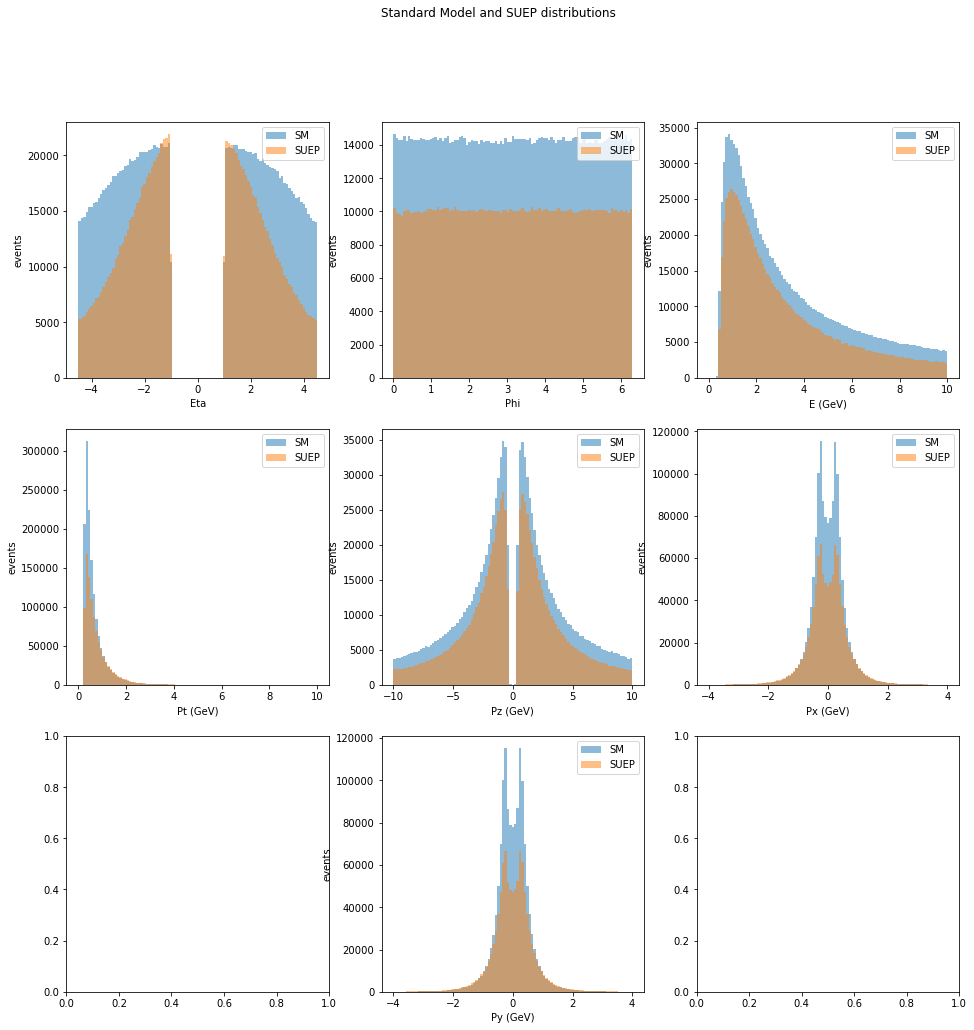

In [9]:



fig, axs = plt.subplots(3,3,sharey=False,figsize=(16,16)) # Idefine a 3x3 plot matrix syste,

fig.suptitle('Standard Model and SUEP distributions') #title


bins = np.linspace(0,10,100) #
axs[1,0].hist(Ptdef, bins, alpha=0.5, label='SM')
axs[1,0].hist(ptSUEP, bins, alpha=0.5, label='SUEP')
axs[1,0].legend(loc='upper right')
axs[1,0].set_ylabel("events")
axs[1,0].set_xlabel("Pt (GeV)")

bins = np.linspace(-4.5,4.5,100)
axs[0,0].hist(Etadef, bins, alpha=0.5, label='SM')
axs[0,0].hist(etaSUEP, bins, alpha=0.5, label='SUEP')
axs[0,0].legend(loc='upper right')
axs[0,0].set_ylabel("events")
axs[0,0].set_xlabel("Eta")

bins = np.linspace(0,2*np.pi,100)
axs[0,1].hist(Phidef, bins, alpha=0.5, label='SM')
axs[0,1].hist(phiSUEP, bins, alpha=0.5, label='SUEP')
axs[0,1].legend(loc='upper right')
axs[0,1].set_ylabel("events")
axs[0,1].set_xlabel("Phi")

bins = np.linspace(0,10,100)
axs[0,2].hist(Edef, bins, alpha=0.5, label='SM')
axs[0,2].hist(ESUEP, bins, alpha=0.5, label='SUEP')
axs[0,2].legend(loc='upper right')
axs[0,2].set_ylabel("events")
axs[0,2].set_xlabel("E (GeV)")

bins = np.linspace(-10,10,100)
axs[1,1].hist(Pzdef, bins, alpha=0.5, label='SM')
axs[1,1].hist(PzSUEP, bins, alpha=0.5, label='SUEP')
axs[1,1].legend(loc='upper right')
axs[1,1].set_ylabel("events")
axs[1,1].set_xlabel("Pz (GeV)")

bins = np.linspace(-4,4,100)
axs[1,2].hist(Pxdef, bins, alpha=0.5, label='SM')
axs[1,2].hist(PxSUEP, bins, alpha=0.5, label='SUEP')
axs[1,2].legend(loc='upper right')
axs[1,2].set_ylabel("events")
axs[1,2].set_xlabel("Px (GeV)")

bins = np.linspace(-4,4,100)
axs[2,1].hist(Pydef, bins, alpha=0.5, label='SM')
axs[2,1].hist(PySUEP, bins, alpha=0.5, label='SUEP')
axs[2,1].legend(loc='upper right')
axs[2,1].set_ylabel("events")
axs[2,1].set_xlabel("Py (GeV)")



plt.savefig('Comparison_SUEP_input_AE4_7Variables_10k_Eta11_NoNorm_0.5_0.5.png',dpi=300)

 Now the Encoder begins. After training with several models, the one which generated a lower error of reconstruction was the Convolutional Layers one. Therefore, it was thought to be a good idea to create a 3 Conv2D layer system, reducing the dimensionality of the matrix to 104/8 = 13. It is important that each reduction of dimensionality considers an even number (104/2 = 52/2 = 26/2 =13); if not, the decoder would construct backwards in a wrong way and the Output from decoder would have different dimensionality that the encoder. For layers the LeakyRelu activation function is good and the padding has to be the same if a direct reduction of the dimensionality to the half of the input wants to be done. 
 
 The last layer has to have a sigmoid activation function (recommended and all AEs and VAEs tutorials). In addition, the number of neurons of the layes increase whilst the dimensinality decreases (other configuration of the number of neurons per layer is succeptible to be changed as the search of the optimous parameters is substantially difficult).

In [10]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(104,104,1)), #Input of the AE
      layers.Conv2D(16, (3, 3),strides=(2,2), activation='LeakyReLU', padding='same'),
      layers.Conv2D(32, (3, 3), strides=(2,2), activation='LeakyReLU', padding='same'),
      layers.Conv2D(64, (3, 3), strides=(2,2), activation='LeakyReLU', padding='same')]) #Different layers with different number of neurons


    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(64, (3, 3), strides=(2,2), activation='LeakyReLU', padding='same'),  #Decoder buildup 
      layers.Conv2DTranspose(32, kernel_size=3, strides=(2,2), activation='LeakyReLU', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=(2,2),activation='LeakyReLU', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')]) #The output is the same dimensionality as Decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()


Here I define the Sigma Loss Function. This is the second approach followed after the Mean Square Error one. Fore more information about this lost function just check in SUEP paper page 13.

In [11]:
#This cell of for building the loss function we are using as the anomaly score

def sigmaf(y_pred): #I define the exponential
    sigma=1./(1.+2.7182818284590**(-y_pred))
    return sigma

def custom_loss_function(y_true, y_pred): #I obtain the variable to be minimized
    global b, cousa, cousa2, error
    cousa=y_true
    cousa2=y_pred
    suma=abs((y_pred-(1./(1.+2.7182818284590**(-y_true))))**3)
    suma=sum(suma)
    error=suma/b
    return error

#losses.MeanSquaredError()

In [12]:
autoencoder.compile(optimizer='adam',run_eagerly=True, loss=losses.MeanSquaredError()) #I compile the model
#On loss I can put either losses.MeanSquaredError() or custom_loss_function in order to select the Lost Function

Now we run the AE. The number of epochs and batch_size has to be the one that the reconstruction error is about to get plain. The less batch_size we take, the more time it spends each epoch but deeper the training is.  

In [13]:
history=autoencoder.fit(deftrain, deftrain,
                epochs=40, batch_size=16,
                shuffle=True,
                validation_data=(deftest, deftest))

print('loss',history.history['loss'])


Epoch 1/40
163/163 [==============================] - 24s 148ms/step - loss: 0.0375 - val_loss: 0.0222
Epoch 2/40
163/163 [==============================] - 25s 153ms/step - loss: 0.0215 - val_loss: 0.0208
Epoch 3/40
163/163 [==============================] - 25s 155ms/step - loss: 0.0199 - val_loss: 0.0193
Epoch 4/40
163/163 [==============================] - 26s 157ms/step - loss: 0.0184 - val_loss: 0.0181
Epoch 5/40
163/163 [==============================] - 26s 159ms/step - loss: 0.0175 - val_loss: 0.0172
Epoch 6/40
163/163 [==============================] - 26s 160ms/step - loss: 0.0165 - val_loss: 0.0157
Epoch 7/40
163/163 [==============================] - 26s 161ms/step - loss: 0.0144 - val_loss: 0.0132
Epoch 8/40
163/163 [==============================] - 26s 160ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 9/40
163/163 [==============================] - 26s 162ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 10/40
163/163 [==============================] - 29s 176ms/step - l

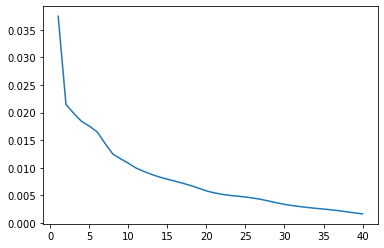

In [14]:
epochs=np.linspace(1,40,40) #Evolution of the epochs along the time
plt.plot(epochs,history.history['loss'])

In [15]:
#Here we can see the reconstruction lost for SM

reconstructionstest = autoencoder.predict(deftest) #Reconstruction for SM Test Set
test_loss = tf.keras.losses.mae(reconstructionstest[:,:,:,0], deftest) #We take the [:,:,:,0] because the output is a tensor of 4 dimensions (we are taking in reality the whole content)
test_array= test_loss.numpy()



12/12 [==============================] - 1s 112ms/step


In [16]:
reconstructions_SUEP = autoencoder.predict(deftrainSUEP) #We do the same procedure for the SUEP train set
train_loss_SUEP = tf.keras.losses.mae(reconstructions_SUEP[:,:,:,0], deftrainSUEP)
train_SUEP_array= train_loss_SUEP.numpy()


12/12 [==============================] - 1s 102ms/step


Now we calculate the reconstrution lost through an anomaly score. In order to do so, we take the test set for SM (deftest) and SUEP (deftrain_SUEP) and apply the calculations necessary to obtain one value for the anomaly score for event. Below can be found the anomaly scores considering the Sigma Function and MSE.

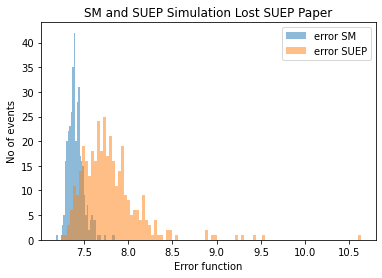

In [17]:
#No we apply the reconstruction lost from SUEP paper to the reconstructed 
 
def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest): #For SM anomaly score per event is calculated
    suma=0
    for j in range(b):
        for k in range(b):
            numerador=np.abs(reconstructionstest[i,j,k,0]-sigma(deftest[i,j,k]))**3
            suma+=numerador
    error=suma/b
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP): #Same for the SUEPs anomaly score
    suma=0
    for j in range(b):
        for k in range(b):
            numerador=np.abs(reconstructions_SUEP[i,j,k,0]-sigma(deftrainSUEP[i,j,k]))**3
            suma+=numerador
    errorSUEP=suma/b
    erroreventSUEP.append(errorSUEP)
#Now, both distributions are plotted, the number of bins is of course succeptible to be changed. Finally we save the image
    
plt.hist(errorevent, bins=40,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=100,alpha=0.5,label='error SUEP')
plt.title('SM and SUEP Simulation Lost SUEP Paper')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('LossNoPT_DeltaRij_MSE_LossDeltaRij_Norm_Eta11_10k_104tracks.png', dpi=400)


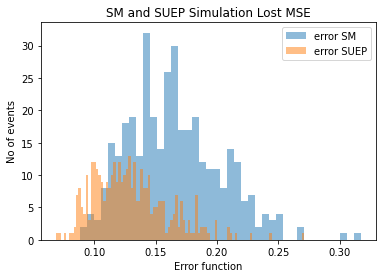

In [18]:
#No we apply the reconstruction lost considerin as Anomaly Score the Mean Square Error from the data.

def sigma(a):
        sigma=1./(1.+np.exp(-a))
        return sigma

errorevent=[]
for i in range(cuentatest):
    suma=0
    for j in range(b):
        for k in range(b):
            numerador=np.abs(reconstructionstest[i,j,k,0]-deftest[i,j,k])**2
            suma+=numerador
    error=suma/b
    errorevent.append(error)
    
erroreventSUEP=[]
for i in range(cuentatrainSUEP):
    suma=0
    for j in range(b):
        for k in range(b):
            numerador=np.abs(reconstructions_SUEP[i,j,k,0]-deftrainSUEP[i,j,k])**2
            suma+=numerador
    errorSUEP=suma/b
    erroreventSUEP.append(errorSUEP)

plt.hist(errorevent, bins=40,alpha=0.5,label='error SM')
plt.hist(erroreventSUEP, bins=100,alpha=0.5,label='error SUEP')
#plt.xscale('log')
plt.title('SM and SUEP Simulation Lost MSE')
plt.xlabel("Error function")
plt.ylabel("No of events")
plt.legend(loc='best')
plt.savefig('LossNoPT_DeltaRij_MSE_LossMSE_Norm_Eta11_10k_104 tracks.png', dpi=400)

 Possible thing to be done in future:
 
 1) Change the number of neurons per layer (go from more to less neurons instead of lower to higher)
 2) Work with a SM scenario considering only muons with an acceptance on their momentum
 3) Increase even higher the number of tracks (difficult to some extent, as the data from SM has to be considerable)
 4) Try this same approach but with the VAE instead of an AE.